In [3]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf

In [4]:
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [5]:
# Clear tf session, if run previously
tf.keras.backend.clear_session()

In [6]:
# Load data and preprocess
# Load simulated and anonimized dataset
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
# Fichier lu avec toutes les colonnes
print(theor.shape)
#print(theor.head())
theor = theor.iloc[1:,]
# la premiere ligne des groupes d'espace est supprimé
theor_arr = theor.values
#les valeurs sont placées dans un tableau
print(theor_arr.shape)
print(theor_arr)

# Load experimental data as dataframe
#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
# Fichier lu avec toutes les colonnes
#print(exp.head())

#exp_arr = exp.values
#les valeurs sont placées dans un tableau
#print(exp_arr.shape)

(2402, 1468)
(2401, 1468)
[[  2.       0.       2.     ...   0.       2.       0.    ]
 [  2.02     0.       2.02   ...   0.       2.02     0.    ]
 [  2.04     0.       2.04   ...   0.       2.04     0.    ]
 ...
 [ 49.96   192.669   49.96   ...  32.0341  49.96    20.1817]
 [ 49.98   160.221   49.98   ...  25.6008  49.98    17.0342]
 [ 50.     133.578   50.     ...  23.0723  50.      16.2182]]


In [24]:
# Space group management
# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
# Fichier lu avec toutes les colonnes et toutes les lignes
label_theo = label_theo[1].tolist()
# Fait une liste des groupes d'espace à partir des valeurs de la colonne 1
#print(label_theo)
label_t=np.zeros([len(label_theo),])
for i in range(len(label_theo)):
    label_t[i]=space_group_enc.index(label_theo[i])
print(label_t.shape)

#Converts a class vector (integers) to binary class matrix.
num_classes = 4
test_categorical = tf.keras.utils.to_categorical(label_t, num_classes, dtype='float32')
print(test_categorical)
# Load experimental class labels
#label_exp = pd.read_csv('Datasets/label_exp.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])
# Fait une liste à partir des valeurs de la colonne 1

# Load class enconding
space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])
# Fait une liste des groupes d'espace à partir des valeurs de la colonne 1 en sautant la premiere ligne
#print(label_theo)
print(space_group_enc)

#print(len(label_theo))
#print(exp_arr_new.shape)
#print(label_exp.shape)

(1468,)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
['0D', '1D', '2D', '3D']


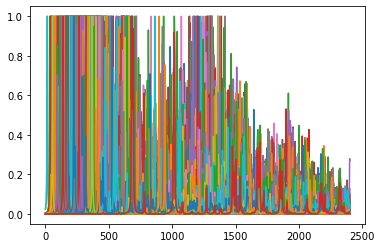

In [12]:
# Normalize data for training
ntheor = normdata(theor_arr)
# Normalize experimental data
#nexp = normdata(exp_arr)

plt.plot(ntheor)
plt.show()

(2401, 1468)
(2401, 734)


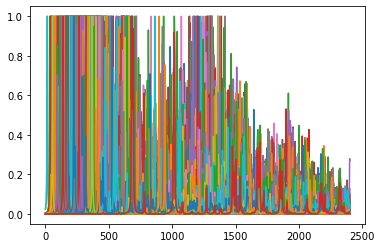

(734,)
(734, 2401, 1)


In [17]:
#avant
print(theor_arr.shape)
#print(exp_arr.shape)
#apres
print(ntheor.shape)
#print(nexp.shape)

plt.plot(ntheor)
plt.show()


#Ici label_theo toujours pas bon
# Define spectral range for data augmentation
exp_min = 0
exp_max = 2000 
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min
# Specify how many data points we augmented
th_num = 734

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])
    
print(label_t.shape)

#prepare X et Y
X_th = np.transpose(ntheor)
Y_th = label_t

X_th = X_th.reshape(734, 2401, 1)
print(X_th.shape)

In [12]:
# Introduction de set de test à partir de la base de données
from sklearn.model_selection import train_test_split
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_test, Y_th_train, Y_th_test = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)
print(X_th_train.shape)
print(Y_th_train.shape)

(587, 2401, 1)
(587,)


In [ ]:
# Training parameters
batch_size = 128
n_epochs = 50
n_classes = 4

# Create the model
model = tf.keras.models.Sequential()

# Convolution Layers
model.add(tf.keras.layers.Conv1D(32, 8, activation='relu', input_shape=(2401, 1), padding='same'))
model.add(tf.keras.layers.Conv1D(63, 5, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'))
#model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'))

# Dense Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

# Optimizer
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile
model.compile(loss=loss_object,
              optimizer=optimizer,
              metrics=['acc'])

# Train model
model.fit(X_th_train, 
          Y_th_train,
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data=(X_th_test, Y_th_test)
          )

Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 4s 7ms/sample - loss: 1.3222 - acc: 0.3663 - val_loss: 1.2102 - val_acc: 0.4626
Epoch 2/50
587/587 [==============================] - 4s 6ms/sample - loss: 1.1393 - acc: 0.4617 - val_loss: 1.2129 - val_acc: 0.3878
Epoch 3/50
587/587 [==============================] - 4s 6ms/sample - loss: 1.0834 - acc: 0.5213 - val_loss: 1.1985 - val_acc: 0.4150
Epoch 4/50
587/587 [==============================] - 4s 6ms/sample - loss: 0.9529 - acc: 0.5911 - val_loss: 1.3533 - val_acc: 0.4218
Epoch 5/50
587/587 [==============================] - 4s 6ms/sample - loss: 0.8398 - acc: 0.6320 - val_loss: 1.4367 - val_acc: 0.4490
Epoch 6/50
587/587 [==============================] - 4s 6ms/sample - loss: 0.6962 - acc: 0.7172 - val_loss: 1.6851 - val_acc: 0.4898
Epoch 7/50
587/587 [==============================] - 4s 6ms/sample - loss: 0.5515 - acc: 0.7632 - val_loss: 1.9567 - val_acc: 0.4762
Epoch 8/50
587/5

Train on 587 samples, validate on 147 samples
Epoch 1/100
587/587 [==============================] - 0s 588us/sample - loss: 1.3656 - acc: 0.3935 - val_loss: 1.3351 - val_acc: 0.4626
Epoch 2/100
587/587 [==============================] - 0s 153us/sample - loss: 1.3131 - acc: 0.4412 - val_loss: 1.2921 - val_acc: 0.4762
Epoch 3/100
587/587 [==============================] - 0s 141us/sample - loss: 1.2690 - acc: 0.4378 - val_loss: 1.2578 - val_acc: 0.4762
Epoch 4/100
587/587 [==============================] - 0s 134us/sample - loss: 1.2324 - acc: 0.4395 - val_loss: 1.2293 - val_acc: 0.4762
Epoch 5/100
587/587 [==============================] - 0s 127us/sample - loss: 1.2017 - acc: 0.4412 - val_loss: 1.2069 - val_acc: 0.4762
Epoch 6/100
587/587 [==============================] - 0s 119us/sample - loss: 1.1774 - acc: 0.4395 - val_loss: 1.1901 - val_acc: 0.4762
Epoch 7/100
587/587 [==============================] - 0s 110us/sample - loss: 1.1583 - acc: 0.4378 - val_loss: 1.1772 - val_acc: 0.

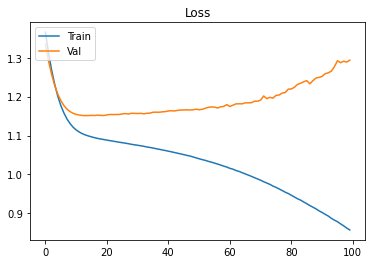

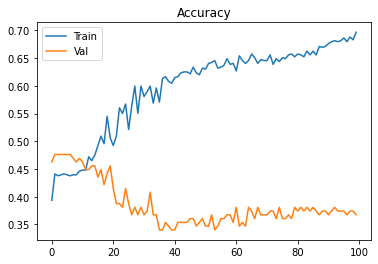

In [9]:
# Perform training and cross-validation
model = tf.keras.models.Sequential()

#Add layers
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["acc"]
)

history = model.fit(X_th, Y_th, epochs=100, validation_split=0.2)

loss_curve = history.history["loss"]
acc_curve = history.history["acc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_acc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()